## Use the PONE model to test
test the cases from `sample-300.txt`, `sample-300-tgt.txt`, `pred.txt`

In [1]:
from utils import *
from hybird import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import interpolate
from scipy.special import softmax
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import pickle
import numpy as np
from tqdm import tqdm
from bert_score import score
from mpl_toolkits.mplot3d import Axes3D
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
%matplotlib inline
%matplotlib widget

I1126 04:58:47.623613 140284317333312 file_utils.py:39] PyTorch version 1.2.0+cu92 available.
I1126 04:58:47.659158 140284317333312 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
!python /home/lt/utils/weblogin.py

2019-11-26 04:58:49
login_ok,bQ0pOyR6IX%2Fu0akbf5QES0glrbCtHF7Gw%2Bt2%2FqhCBBTmz0PW14zxUd5rrzUTcq6bko7xGFi4v845xQjku9b0%2B80EydOQdCsOvqryHIr%2FK40aw%2FUvaDA9QuHo2yKEGy36v1g9v04s9ruH63uh9YXSOV2QIZJ1urvm%2Fwky0a%2Fk2%2B3r3MippWvhtju1lg%3D%3D,bQ0o5ZADI11BgO3HLndd%2Bxt3LbV4WDOtcmv8IJpul%2FVd2ciqIATT7Ro5%2BW%2BAJIjI1yL0ppXlRZiND%2BsfVVN5Ug78WlHHo%2F2%2BVhHsvwIy7MnC7BZ%2BGzoWJ3WZ7TijMolwnME6nQe1G9AHF8mFw06OBu%2F0dFcYbHaMwHzlzhJF43A%3D


### Init and prepare the data

In [3]:
dataset = 'dailydialog'
mode = 'trepn'
version = 1
model_name = f'EPN-RUBER-{dataset}-{mode}-{version}'

model = BERT_RUBER(dataset, model_name, test=True)

[!] Load the model from ./ckpt/dailydialog/EPN-RUBER-dailydialog-trepn-1/Acc_0.808_vloss_0.4423_epoch_66_weighted_True.pt, threshold 1


In [4]:
dataset = 'dailydialog'
mode = 'origin'
version = 1
model_name = f'EPN-RUBER-{dataset}-{mode}-{version}'

model1 = BERT_RUBER(dataset, model_name, test=True)

[!] Load the model from ./ckpt/dailydialog/EPN-RUBER-dailydialog-origin-1/Acc_0.8094_vloss_0.5791_epoch_23_weighted_False.pt, threshold 1


In [5]:
context_path = f'./data/annotator/{dataset}/sample-300.txt'
groundtruth_path = f'./data/annotator/{dataset}/sample-300-tgt.txt'
reply_path = f'./data/annotator/{dataset}/pred1.txt'
human_path1 = f'./data/annotator/{dataset}/1/annotate.csv'
human_path2 = f'./data/annotator/{dataset}/2/annotate.csv'
human_path3 = f'./data/annotator/{dataset}/3/annotate.csv'

In [6]:
def read_txt(path):
    d = []
    with open(path) as f:
        for line in f.readlines():
            d.append(line.strip())
    return d

def human_csv(path):
    d = []
    with open(path) as f:
        for line in f.readlines():
            line = float(line.strip().split(',')[-1])
            d.append(line)
    return d

In [7]:
context = read_txt(context_path)
groundtruth = read_txt(groundtruth_path)
reply = read_txt(reply_path)
human1 = human_csv(human_path1) + [0] * 200
human2 = human_csv(human_path2) + [0] * 200
human3 = human_csv(human_path3) + [0] * 200
human = np.mean(np.array([human1, human2, human3]), axis=0)
len(context), len(groundtruth), len(reply), len(human)

(300, 300, 300, 300)

### Test and get the scores 

In [7]:
lang = 'english.pkl' if dataset in ['dailydialog', 'cornell'] else 'chinese.pkl'
with open(f'./data/{lang}', 'rb') as f:
    dic = pickle.load(f)

In [ ]:
# test and get all the score
scores = []
filter = [73, 62, 58, 98]
for idx, (c, g, r, h) in tqdm(enumerate(zip(context, groundtruth, reply, human))):
    if idx not in filter:
        continue
    if not r:
        r = '<unk>'
    refer, unrefer, ruber = model.test(c, g, r)
    _, bert_ruber, _ = model1.test(c, g, r)
    bert_ruber, unrefer = round(bert_ruber, 4), round(unrefer, 4)
    bleu = cal_BLEU(g.split(), r.split(), ngram=4)
    EA = cal_embedding_average(g.split(), r.split(), dic)
    # rouge = cal_ROUGE(g.split(), r.split())
    _, _, bert_score = score([r], [g], lang='en', verbose=False)
    bert_score = bert_score.tolist()[0]
    #bert_score = 0
    scores.append((c, g, r, bleu, EA, bert_score, bert_ruber, unrefer, h))

In [19]:
pd.set_option('max_colwidth', 200)
pd.set_option('max_rows', 500)
df = pd.DataFrame(scores, columns=['Context', 'GTS', 'Reply', 'bleu', 'EA', 'BERTScore', 
                                   'BERT-RUBER', 'PoNe', 'human'])

In [20]:
df.head(10)     # 0.729752

,Context,GTS,Reply,bleu,EA,BERTScore,BERT-RUBER,PoNe,human
0,Sure . I usually have my lunch here . The food is tasty and they offer a big variety .,Let's line up . The steak is very inviting . I'll have it .,I didn ’ t know that . That sounds pretty good . Can you come here for a few minutes ?,0.255528,0.871267,0.856554,0.3236,0.5631,0.533333
1,I can type 100 Chinese words a minute and take dictation in English at 150 words a minute .,Can you operate computers skillfully ?,So you don't have a printer in the box ?,0.232523,0.791877,0.879296,0.9626,0.0554,0.066667
2,"Tell me a little bit about yourself , please .",My name is Dunlin and I live in Beijing . I was born in 1980 . I will graduate from Peking University this July . I have majored in accounting .,Thank you very much .,0.198792,0.763089,0.816806,0.9517,0.2903,0.200000
3,That sounds nice .,You should go get yours .,"Yes , it is . Let's go and have a drink .",0.192591,0.850699,0.886068,0.6996,0.6814,0.600000


### Decision boundary

In [13]:
# get the label
def draw(model, m, embeddings, path):
    labels = []
    error_count = 0
    c, g = sentences[0], sentences[1]
    for r in sentences[2:]:
        refer, unrefer, ruber = model.test(c, g, r)
        if unrefer >= 0.5:
            labels.append(1)
        else:
            labels.append(0)
            
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)

    ax.scatter(embeddings[1, 0], embeddings[1, 1], marker='*', c='r', label='groundtruth')
    ax.scatter(embeddings[32, 0], embeddings[32, 1], marker='o', c='r', label='positive')
    
    f1, f2 = False, False

    for idx, (x, l) in tqdm(enumerate(zip(embeddings[2:], labels))):
        if l == 1:
            color = 'o'
        else:
            color = 's'
        if idx < 30:
            ax.scatter(x[0], x[1], marker=color, c='r')
        else:
            if color == 'o':
                if f1:
                    ax.scatter(x[0], x[1], marker='s', color='orange')
                else:
                    ax.scatter(x[0], x[1], marker='s', color='orange', label='error')
                    f1 = True
            else:
                if f2:
                    ax.scatter(x[0], x[1], marker=color, c='b')
                else:
                    ax.scatter(x[0], x[1], marker=color, c='b', label='negative')
                    f2 = True
            
    # ax.set_title(f'Model: {m}', fontsize=20)
    ax.legend()
    plt.xticks([])
    plt.yticks([])
    # plt.savefig(path, format='eps', dpi=300)
    plt.savefig(path, dpi=600)
    return labels

Would you like something to drink , sir ? Do you prefer coffee or tea ?
Thank you . Coffee , please .


/home/lt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
330it [00:00, 472.06it/s]
330it [00:00, 381.87it/s]


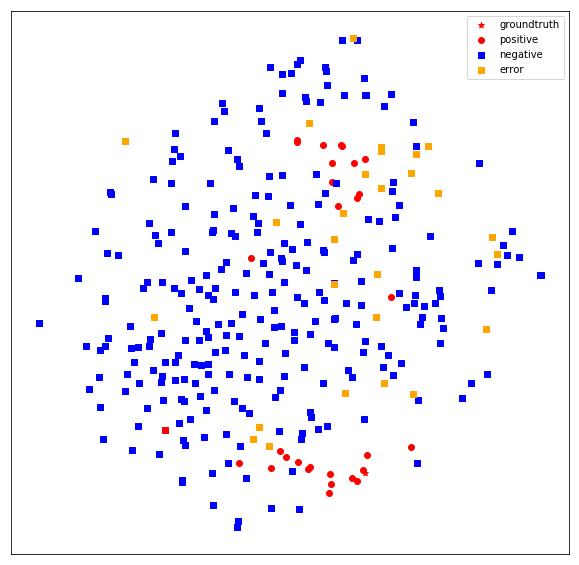

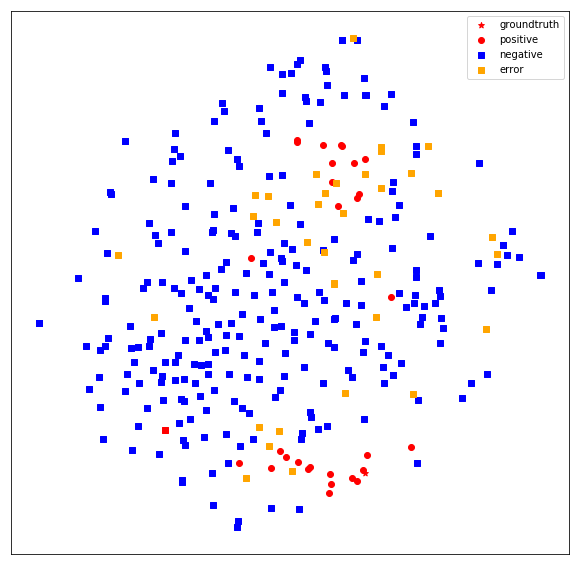

In [20]:
c, g = context[4], groundtruth[4]
print(f'{c}\n{g}')
corpus = read_txt('./data/dailydialog/tgt-train.txt')

# read from the file
random_n = random.sample(corpus, 300)
# with open('./img/6-sentences.txt', 'r') as f:
#     random_n = eval(f.read().strip())[32:]

positive_n = ['Coffee please',
              'I prefer tea.', 
              'What kind of coffee do you have',
              "I don't like tea. It's too bitter",
              'Coffee , thank you',
              'coffee please , and I would like to order some breakfast. What kind of food do you have',
              'I do not have much money. Which is cheaper, coffee or tea?',
              'Coffee, strong, no sugar',
              'No, thank you',
              'I do not feel like drinking. I am hungry now',
              'No, I do not want them . I want to speak to your manager', 
              'Hot coffee, packed.', 
              'Do you have black tea?',
              'Coffee is too expensive. I want some tea',
              'Tea, with some honey',
              'Anything else, like coke?',
              'I am waiting for someone. Can I order later?',
              'I prefer coffee, hot.', 
              'That is really a hard choice , i like both of them',
              'I like both , give me coffee and tea .',
              'How much is a cup of coffee ?',
              'Do you have Chinese tea here ?', 
              'Would you recommend tea or coffee ?',
              'tea and some salads , thanks',
              'I would like some tea',
              'Could you give me a cup of tea , please ?',
              'Which one is cheaper , coffee or tea ?',
              'Oh , I need some coffee to perk me up .',
              'No, I would like a glass of wine .',
              'Tea , please']
# c, g, positive_n
sentences = [c, g]
sentences.extend(positive_n)
sentences.extend(random_n)

# bert
bc = BertClient()
embeddings = bc.encode(sentences)

# draw
# plt.figure(figsize=(20, 10))
# ax1 = plt.subplot(1, 2, 2)
# ax2 = plt.subplot(1, 2, 1)

# estimator = PCA(n_components=2)
# em = estimator.fit_transform(embeddings)

tsne = TSNE(n_components=2)
tsne.fit_transform(embeddings)
em = tsne.embedding_

label1 = draw(model, 'PoNe', em, './img/1-11-20-1.png')
label2 = draw(model1, 'BERT-RUBER', em, './img/1-11-20-2.png')

In [21]:
length = len(positive_n)
print(f'{label1[:length]}\n{label2[:length]}')
# error count
error_count1 = [label1[:length].count(0), label1[length:].count(1)]
error_count2 = [label2[:length].count(0), label2[length:].count(1)]
print(error_count1, error_count2)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 28] [1, 37]


In [398]:
with open('./img/em.pkl', 'wb') as f:
    pickle.dump(em, f)

### Show the examples in the paper

In [429]:
from utils import read_file
dataset, t, pointer = 'dailydialog', 0.03, 864

In [163]:
weight_matrix_path = f'./data/{dataset}/bert-weight-matrix.pkl'
weight_matrix = read_file(weight_matrix_path)

In [113]:
print(f'weight_matrix shape: {weight_matrix.shape}')
# read the target file
tgt_path = f'./data/{dataset}/tgt-train.txt'
with open(tgt_path) as f:
    corpus = []
    for i in f.readlines():
        corpus.append(i.strip())
    print(f'target shape: {len(corpus)}')

weight_matrix shape: (45000, 45000)
target shape: 45000


In [435]:
weight_m = weight_matrix[pointer]    # [45000]
ssim = softmax(weight_m / t)
sidx = np.random.choice(ssim.shape[0], p=ssim)

In [437]:
print(f'Target: {corpus[pointer]}\n')
print(f'Chosen: {corpus[sidx]}\n')
print(f'Random: {random.sample(corpus, 1)[0]}\n')

Target: I'm an engineer at IBM .

Chosen: I used to work as a teacher .

Random: Wow . You ’ re really a heavy smoker .



### The statistics
#### 1. show the figure

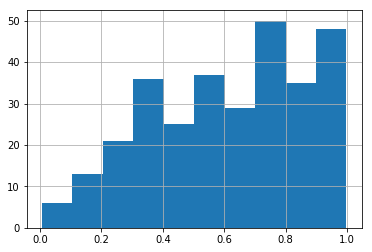

In [10]:
df['unrefer'].hist()

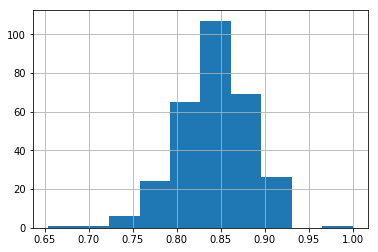

In [43]:
df['refer'].hist()

In [44]:
v = df['human'].values
ruler = {(0.0, 0.2): 0, (0.2, 0.4): 0, (0.4, 0.6): 0, (0.6, 0.8): 0, (0.8, 1.0): 0}
for i in v:
    i = float(i)
    if 0.0 <= i < 0.2:
        ruler[(0.0, 0.2)] += 1
    elif 0.2 <= i < 0.4:
        ruler[(0.2, 0.4)] += 1
    elif 0.4 <= i < 0.6:
        ruler[(0.4, 0.6)] += 1
    elif 0.6 <= i < 0.8:
        ruler[(0.6, 0.8)] += 1
    else:
        ruler[(0.8, 1.0)] += 1
pprint.pprint(ruler)

{(0.0, 0.2): 124,
 (0.2, 0.4): 28,
 (0.4, 0.6): 15,
 (0.6, 0.8): 42,
 (0.8, 1.0): 91}


In [45]:
human = list(map(float, human))
print(pearsonr(human, df['unrefer'].values))
print(spearmanr(human, df['unrefer'].values))

(0.47774433061141264, 1.6420795594014865e-18)
SpearmanrResult(correlation=0.4871749542944893, pvalue=2.7517604585154095e-19)


#### 2. fuzzy data by threshold

**Without Fuzzy threshold**  

| model  | fuzzy ratio | fuzzy wrong ratio  | absolute ratio  | absolute wrong ratio  | total wrong ratio  |
|---|---|---|---|---|---|
| origin BERT-RUBER  | 0.27  | 0.14(51.85%)  | 0.73  | 0.1467(20.10%)  | 0.2867  |
| data augmentation  | 0.3833  | 0.12(31.31%)  | 0.6167  | 0.1267(20.54%)  | **0.2467**  |
| enhancing negative  | **0.5167**  | **0.1933**(37.41%)  | 0.4833  | **0.0733**(15.17%)  | 0.2667  |
| enhancing positive  | 0.2367  | 0.1233(52.09%)  | 0.7633  | 0.1667(21.84%)  | 0.29  |
| EPN-RUBER  | 0.2267  | 0.1(44.11%)  | **0.7733**  | 0.1767(22.85%)  | 0.2767  |

**With Fuzzy threshold 0.3**

**With Fuzzy threshold 0.2**

| model  | fuzzy ratio | fuzzy wrong ratio  | absolute ratio  | absolute wrong ratio  | total wrong ratio  |
|---|---|---|---|---|---|
| origin BERT-RUBER  | 0.27  | 0.14(51.85%)  | 0.73  | 0.1467(20.10%)  | 0.2867  |
| data augmentation  | 0.3833  | 0.12(31.31%)  | 0.6167  | 0.1267(20.54%)  | **0.2467**  |
| enhancing negative  | **0.5167**  | **0.1933**(37.41%)  | 0.4833  | **0.0733**(15.17%)  | 0.2667  |
| enhancing positive  | 0.12  | 0.05(41.67%)  | 0.88  | 0.2033(23.10%)  | 0.2533  |
| EPN-RUBER  | 0.2267  | 0.1(44.11%)  | **0.7733**  | 0.1767(22.85%)  | 0.2767  |

**With Fuzzy threshold 0.15**

| model  | fuzzy ratio | fuzzy wrong ratio  | absolute ratio  | absolute wrong ratio  | total wrong ratio  |
|---|---|---|---|---|---|
| origin BERT-RUBER  | 0.27  | 0.14(51.85%)  | 0.73  | 0.1467(20.10%)  | 0.2867  |
| data augmentation  | 0.3833  | 0.12(31.31%)  | 0.6167  | 0.1267(20.54%)  | **0.2467**  |
| enhancing negative  | **0.5167**  | **0.1933**(37.41%)  | 0.4833  | **0.0733**(15.17%)  | 0.2667  |
| enhancing positive  | 0.2033  | 0.1(49.18%)  | 0.7967  | 0.16(20.08%)  | 0.26  |
| EPN-RUBER  | 0.2267  | 0.1(44.11%)  | **0.7733**  | 0.1767(22.85%)  | 0.2767  |

**With Fuzzy threshold 0.1**

| model  | fuzzy ratio | fuzzy wrong ratio  | absolute ratio  | absolute wrong ratio  | total wrong ratio  |
|---|---|---|---|---|---|
| origin BERT-RUBER  | 0.27  | 0.14(51.85%)  | 0.73  | 0.1467(20.10%)  | 0.2867  |
| data augmentation  | 0.3833  | 0.12(31.31%)  | 0.6167  | 0.1267(20.54%)  | **0.2467**  |
| enhancing negative  | **0.5167**  | **0.1933**(37.41%)  | 0.4833  | **0.0733**(15.17%)  | 0.2667  |
| enhancing positive  | 0.3967  | 0.1367(34.46%)  | 0.6033  | 0.13(21.55%)  | 0.2667  |
| EPN-RUBER  | 0.2933  | 0.1067(36.38%)  | **0.7067**  | 0.1433(20.28%)  | 0.25  |

In [46]:
threshold = 0.2   # 0.2 ~ 0.8 is the fuzzy zone

In [47]:
absolute, fuzzy, wronglabel1, wronglabel2 = 0, 0, 0, 0
ab, fu, wr1, wr2 = [], [], [], []
for idx, i in enumerate(df['unrefer'].values):
    if threshold < i < 1 - threshold:
        fuzzy += 1
        fu.append((context[idx], reply[idx], i, human[idx]))
        if (float(human[idx]) > 0.5 and i < 0.5) or (float(human[idx]) < 0.5 and i > 0.5):
            wronglabel1 += 1
            wr1.append((context[idx], reply[idx], i, human[idx]))
    else:
        absolute += 1
        ab.append((context[idx], reply[idx], i, human[idx]))
        if (float(human[idx]) > 0.5 and i < 0.5) or (float(human[idx]) < 0.5 and i > 0.5):
            wronglabel2 += 1
            wr2.append((context[idx], reply[idx], i, human[idx]))
print(f'fuzzy ratio {round(fuzzy / 300, 4)}')
print(f'fuzzy wrong ratio {round(wronglabel1 / 300, 4)}')
print(f'absolute ratio {round((300 - fuzzy) / 300, 4)}')
print(f'absolute wrong ratio {round(wronglabel2 / 300, 4)}')
print(f'total wrong ratio {round((wronglabel1 + wronglabel2) / 300, 4)}')

fuzzy ratio 0.66
fuzzy wrong ratio 0.2833
absolute ratio 0.34
absolute wrong ratio 0.0567
total wrong ratio 0.34


### 3. Experiment result

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Xiaohuangji</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Tencent</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Weibo</span></th>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">BERT-RUBER</span></td>
    <td class="tg-lboi">0.40428</td>
    <td class="tg-lboi">0.39786</td>
    <td class="tg-lboi">0.42237</td>
    <td class="tg-lboi">0.39457</td>
    <td class="tg-lboi">0.39371</td>
    <td class="tg-lboi">0.41523</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Data Augmentation</span></td>
    <td class="tg-lboi">0.44484</td>
    <td class="tg-lboi">0.44205</td>
    <td class="tg-lboi">0.43017</td>
    <td class="tg-lboi">0.3954</td>
    <td class="tg-lboi"><span style="font-weight:bold">0.47259</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.48299</span></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Ehancing negative</span></td>
    <td class="tg-lboi">0.41846</td>
    <td class="tg-lboi">0.41309</td>
    <td class="tg-lboi">0.43185</td>
    <td class="tg-lboi">0.39973</td>
    <td class="tg-lboi">0.3945</td>
    <td class="tg-lboi">0.41356</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EP(ft=0.1)</span></td>
    <td class="tg-lboi">0.44777</td>
    <td class="tg-lboi">0.45213</td>
    <td class="tg-lboi"><span style="font-weight:bold">0.44147</span></td>
    <td class="tg-lboi">0.41428</td>
    <td class="tg-lboi">0.41674</td>
    <td class="tg-lboi">0.43387</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EP(ft=0.15)</span></td>
    <td class="tg-lboi">0.44568</td>
    <td class="tg-lboi">0.45678</td>
    <td class="tg-lboi">0.44000</td>
    <td class="tg-g7sd"><span style="font-weight:bold">0.41699</span></td>
    <td class="tg-lboi">0.40873</td>
    <td class="tg-lboi">0.42593</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EP(ft=0.2)</span></td>
    <td class="tg-lboi">0.44591</td>
    <td class="tg-lboi">0.45769</td>
    <td class="tg-lboi">0.43702</td>
    <td class="tg-lboi">0.40058</td>
    <td class="tg-lboi">0.40351</td>
    <td class="tg-lboi">0.42133</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EP(ft=0.3)</span></td>
    <td class="tg-lboi">0.44875</td>
    <td class="tg-lboi">0.46394</td>
    <td class="tg-lboi">0.43172</td>
    <td class="tg-lboi">0.40905</td>
    <td class="tg-lboi">0.39844</td>
    <td class="tg-lboi">0.40434</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EP(ft=0.5)</span></td>
    <td class="tg-lboi">0.44818</td>
    <td class="tg-lboi">0.4599</td>
    <td class="tg-lboi">0.42278</td>
    <td class="tg-lboi">0.40058</td>
    <td class="tg-lboi">0.38873</td>
    <td class="tg-lboi">0.40054</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.1)</span></td>
    <td class="tg-lboi">0.44668</td>
    <td class="tg-lboi">0.45177</td>
    <td class="tg-lboi">0.43471</td>
    <td class="tg-lboi">0.40996</td>
    <td class="tg-lboi">0.41296</td>
    <td class="tg-lboi">0.43138</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.15)</span></td>
    <td class="tg-lboi">0.44724</td>
    <td class="tg-lboi">0.4523</td>
    <td class="tg-lboi">0.43223</td>
    <td class="tg-lboi">0.40804</td>
    <td class="tg-lboi">0.40925</td>
    <td class="tg-lboi">0.42991</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.2)</span></td>
    <td class="tg-lboi">0.43692</td>
    <td class="tg-lboi">0.44494</td>
    <td class="tg-lboi">0.43169</td>
    <td class="tg-lboi">0.40938</td>
    <td class="tg-lboi">0.40741</td>
    <td class="tg-lboi">0.42824</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.3)</span></td>
    <td class="tg-lboi">0.44414</td>
    <td class="tg-lboi">0.45519</td>
    <td class="tg-lboi">0.42891</td>
    <td class="tg-lboi">0.4097</td>
    <td class="tg-lboi">0.39889</td>
    <td class="tg-lboi">0.42243</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.5)</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.45046</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.4599</span></td>
    <td class="tg-lboi">0.42941</td>
    <td class="tg-lboi">0.40891</td>
    <td class="tg-lboi">0.39498</td>
    <td class="tg-lboi">0.42035</td>
  </tr>
</table>

In [297]:
0.1433 / 0.7067

0.20277345408235461

### 4. Fixed result

## Redefine the task and experiment result
Time: `2019.8.3`

### 1. Question:
1. Positive aspect + Negative aspect
2. Positive aspect:
    * Seq2Seq + Enhancing is better than traditional Data augmentation  
        需要注意的是，在 [EDA: Easy Data Augmentation techniques for boosting performance on text classification tasks](https://github.com/jasonwei20/eda_nlp) 的方法中使用了4中不同的自然语言数据增强的方法，但是实际上并不改变最终的结果，对小数据量有所帮助，但是在该场景下，数据量不是限制瓶颈，数据的质量是限制的瓶颈(极端不平衡数据集)。
    * Negative highlight the decision boundary
    * Positive + Negative can achieve better performance
        1. More noise do not use enhance mode in positive aspect
        2. Less noise use enhance mode in positive aspect can achieve better performance
        
### 2. Experiment result
1. Global experiment  
Ehance choose the best fuzzy threshold, `Weibo` dataset have more noise, EDA DA is not so good.
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Xiaohuangji</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Tencent</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">Weibo</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">PTT</span></th>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">BERT-RUBER</span></td>
    <td class="tg-lboi">0.35077</td>
    <td class="tg-lboi">0.33851</td>
    <td class="tg-lboi">0.4559</td>
    <td class="tg-lboi">0.4567</td>
    <td class="tg-lboi">0.39371</td>
    <td class="tg-lboi">0.41523</td>
    <td class="tg-lboi">0.29154</td>
    <td class="tg-lboi">0.3160</td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-BERT-RUBER</span></td>
    <td class="tg-lboi">0.36059</td>
    <td class="tg-lboi">0.3354</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Safe-BERT-RUBER</span></td>
    <td class="tg-lboi">0.35888</td>
    <td class="tg-lboi">0.33966</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-Safe-BERT-RUBER</span></td>
    <td class="tg-lboi">0.3953</td>
    <td class="tg-lboi">0.36977</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Ehancing negative</span></td>
    <td class="tg-lboi">0.36942</td>
    <td class="tg-lboi">0.3656</td>
    <td class="tg-lboi">0.4754</td>
    <td class="tg-lboi">0.46538</td>
    <td class="tg-lboi">0.3945</td>
    <td class="tg-lboi">0.41356</td>
    <td class="tg-lboi">0.30473</td>
    <td class="tg-lboi">0.31944</td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-Ehancing negative</span></td>
    <td class="tg-lboi">0.42701</td>
    <td class="tg-lboi">0.40548</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Safe-Ehancing negative</span></td>
    <td class="tg-lboi">0.38273</td>
    <td class="tg-lboi">0.36505</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-Safe-Ehancing negative</span></td>
    <td class="tg-lboi">0.41957</td>
    <td class="tg-lboi">0.404088</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Seq2Seq DA</span></td>
    <td class="tg-lboi">0.42644</td>
    <td class="tg-lboi">0.42076</td>
    <td class="tg-lboi">0.45917</td>
    <td class="tg-lboi">0.46338</td>
    <td class="tg-lboi">0.47584</td>
    <td class="tg-lboi">0.48394</td>
    <td class="tg-lboi">0.28723</td>
    <td class="tg-lboi">0.28948</td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-Seq2Seq DA</span></td>
    <td class="tg-lboi">0.44855</td>
    <td class="tg-lboi">0.43987</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Safe-Seq2Seq DA</span></td>
    <td class="tg-lboi">0.46201</td>
    <td class="tg-lboi">0.46873</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-Safe-Seq2Seq DA</span></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Enhance DA(ft=0.15)</span></td>
    <td class="tg-lboi">0.46201</td>
    <td class="tg-lboi">0.46873(ft=0.5)</td>
    <td class="tg-lboi">0.47916</td>
    <td class="tg-lboi">0.47402</td>
    <td class="tg-lboi">0.4711</td>
    <td class="tg-lboi">0.4804(100, lr=1e-7, ft=0.05)</td>
    <td class="tg-lboi">0.32298</td>
    <td class="tg-lboi">0.32623(tmep=0.05, pr_choice=60, lr=5e-7, weight_decay=0, ft=0.05)</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Fluent-Enhance DA(ft=0.15)</span></td>
    <td class="tg-lboi">0.47042</td>
    <td class="tg-lboi">0.47154(ft=0.5,ft=0.05 very bad)</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">PN</span></td>
    <td class="tg-lboi">0.47021</td>
    <td class="tg-lboi">0.47264</td>
    <td class="tg-lboi">0.4603</td>
    <td class="tg-lboi">0.46636</td>
    <td class="tg-lboi"><span style="font-weight:bold">0.47271</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.48272</span></td>
    <td class="tg-lboi">0.27583</td>
    <td class="tg-lboi">0.28485(pre_choice=100, temp=0.1)</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">EPN(ft=0.05)</span></td>
    <td class="tg-lboi">0.5098</td>
    <td class="tg-lboi">0.51669(ft=0.1, temp=0.1)</td>
    <td class="tg-lboi">0.48079</td>
    <td class="tg-lboi">0.47169(ft=0.05, temp=0.1, lr=5e-6)</td>
    <td class="tg-lboi">0.47573</td>
    <td class="tg-lboi">0.48368(75, lr=1e-7, temp=0.05, ft=0.05, prechoice=75, step=5)</td>
    <td class="tg-lboi">0.32518</td>
    <td class="tg-lboi">0.33099(75, prechoice=100, temp=0.1, lr=1e-6, ft=0.05)</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Fluent-EPN(ft=0.05)</span></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">tr DA</span></td>
    <td class="tg-lboi">0.43244</td>
    <td class="tg-lboi">0.42484</td>
    <td class="tg-lboi">0.47484</td>
    <td class="tg-lboi">0.47097</td>
    <td class="tg-lboi">0.4358</td>
    <td class="tg-lboi">0.4645</td>
    <td class="tg-lboi">0.35971</td>
    <td class="tg-lboi">0.3804</td>
  </tr>
  <tr>
    <td class="tg-g7sd"><span style="font-weight:bold">Fluent-tr DA</span></td>
    <td class="tg-lboi">0.43551</td>
    <td class="tg-lboi">0.42458</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Enhance trDA(ft=0.15)</span></td>
    <td class="tg-lboi">0.49384</td>
    <td class="tg-lboi">0.48787</td>
    <td class="tg-lboi">0.48003</td>
    <td class="tg-lboi">0.46967(ft=0.05, pre_choice=75, lr=1e-7, temp=0.05, epoches=75)</td>
    <td class="tg-lboi">0.44275</td>
    <td class="tg-lboi">0.46651(lr=1e-7, ft=0.05, epoches=75)</td>
    <td class="tg-lboi">0.35408</td>
    <td class="tg-lboi">0.37241(temp=0.05, lr=1e-7, ft=0.1, epoches=100)</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Fluent-Enhance trDA(ft=0.15)</span></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trPN</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.47818</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.4751</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.49634</span></td>
    <td class="tg-lboi"><span style="font-weight:bold">0.48967</span></td>
    <td class="tg-lboi">0.43505</td>
    <td class="tg-lboi">0.46474</td>
    <td class="tg-lboi">0.3299</td>
    <td class="tg-lboi">0.35808</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trEPN</span></td>
    <td class="tg-lboi">0.49668</td>
    <td class="tg-lboi">0.49101(ft=0.1, temp=0.1)</td>
    <td class="tg-lboi">0.48141</td>
    <td class="tg-lboi">0.47088(lr=1e-7, ft=0.05, temp=0.1, step=5, pre_choice=100)</td>
    <td class="tg-lboi">0.43889</td>
    <td class="tg-lboi">0.45983(ft=0.05, temp=0.1)</td>
    <td class="tg-lboi">0.33831</td>
    <td class="tg-lboi">0.35801</td>
  </tr>
</table>

2. Weight temp ratio, xiaohuangji dataset, one dataset or all the dataset do this analyse ?

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">0.001</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">0.01</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">0.05</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">0.1</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">0.5</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">1</span></th>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Ehancing negative</span></td>
    <td class="tg-lboi">0.40255</td>
    <td class="tg-lboi">0.39977</td>
    <td class="tg-lboi">0.41342</td>
    <td class="tg-lboi">0.40679</td>
    <td class="tg-lboi">0.42085</td>
    <td class="tg-lboi">0.41565</td>
    <td class="tg-lboi">0.41929</td>
    <td class="tg-lboi">0.41767</td>
    <td class="tg-lboi">0.41325</td>
    <td class="tg-lboi">0.40971</td>
    <td class="tg-lboi">0.41182</td>
    <td class="tg-lboi">0.41492</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">PN</span></td>
    <td class="tg-lboi">0.45102</td>
    <td class="tg-lboi">0.44865</td>
    <td class="tg-lboi">0.47021</td>
    <td class="tg-lboi">0.47264</td>
    <td class="tg-lboi">0.46197</td>
    <td class="tg-lboi">0.46091</td>
    <td class="tg-lboi">0.4457</td>
    <td class="tg-lboi">0.44432</td>
    <td class="tg-lboi">0.43054</td>
    <td class="tg-lboi">0.43108</td>
    <td class="tg-lboi">0.43015</td>
    <td class="tg-lboi">0.42702</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trPN</span></td>
    <td class="tg-lboi">0.47936</td>
    <td class="tg-lboi">0.47985</td>
    <td class="tg-lboi">0.47818</td>
    <td class="tg-lboi">0.47510</td>
    <td class="tg-lboi">0.47463</td>
    <td class="tg-lboi">0.47538</td>
    <td class="tg-lboi">0.47177</td>
    <td class="tg-lboi">0.47046</td>
    <td class="tg-lboi">0.46260</td>
    <td class="tg-lboi">0.46379</td>
    <td class="tg-lboi">0.45551</td>
    <td class="tg-lboi">0.45291</td>
  </tr>
</table>

3. Prechoice ratio, xiaohuangji dataset, temp 0.1

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">1</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">10</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">20</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">30</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">40</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">50</span></th>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Ehancing negative</span></td>
    <td class="tg-lboi">0.42489</td>
    <td class="tg-lboi">0.42794</td>
    <td class="tg-lboi">0.424</td>
    <td class="tg-lboi">0.42241</td>
    <td class="tg-lboi">0.43335</td>
    <td class="tg-lboi">0.42911</td>
    <td class="tg-lboi">0.39966</td>
    <td class="tg-lboi">0.39807</td>
    <td class="tg-lboi">0.41481</td>
    <td class="tg-lboi">0.41294</td>
    <td class="tg-lboi">0.41342</td>
    <td class="tg-lboi">0.40679</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">PN</span></td>
    <td class="tg-lboi">0.43734</td>
    <td class="tg-lboi">0.43264</td>
    <td class="tg-lboi">0.44896</td>
    <td class="tg-lboi">0.44809</td>
    <td class="tg-lboi">0.44287</td>
    <td class="tg-lboi">0.44153</td>
    <td class="tg-lboi">0.44425</td>
    <td class="tg-lboi">0.44344</td>
    <td class="tg-lboi">0.4561</td>
    <td class="tg-lboi">0.45228</td>
    <td class="tg-lboi">0.4457</td>
    <td class="tg-lboi">0.44432</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trPN</span></td>
    <td class="tg-lboi">0.44704</td>
    <td class="tg-lboi">0.44489</td>
    <td class="tg-lboi">0.45111</td>
    <td class="tg-lboi">0.44815</td>
    <td class="tg-lboi">0.45955</td>
    <td class="tg-lboi">0.46033</td>
    <td class="tg-lboi">0.46121</td>
    <td class="tg-lboi">0.45817</td>
    <td class="tg-lboi">0.4681</td>
    <td class="tg-lboi">0.46494</td>
    <td class="tg-lboi">0.46982</td>
    <td class="tg-lboi">0.4671</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">60</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">70</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">80</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">90</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">100</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">110</span></th>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">Ehancing negative</span></td>
    <td class="tg-lboi">0.44369</td>
    <td class="tg-lboi">0.44352</td>
    <td class="tg-lboi">0.41478</td>
    <td class="tg-lboi">0.40708</td>
    <td class="tg-lboi">0.42161</td>
    <td class="tg-lboi">0.42512</td>
    <td class="tg-lboi">0.39389</td>
    <td class="tg-lboi">0.39297</td>
    <td class="tg-lboi">0.42125</td>
    <td class="tg-lboi">0.41568</td>
    <td class="tg-lboi">0.40549</td>
    <td class="tg-lboi">0.40146</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">PN</span></td>
    <td class="tg-lboi">0.44798</td>
    <td class="tg-lboi">0.44607</td>
    <td class="tg-lboi">0.44334</td>
    <td class="tg-lboi">0.43595</td>
    <td class="tg-lboi">0.42879</td>
    <td class="tg-lboi">0.42538</td>
    <td class="tg-lboi">0.45584</td>
    <td class="tg-lboi">0.45401</td>
    <td class="tg-lboi">0.4715</td>
    <td class="tg-lboi">0.4692</td>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trPN</span></td>
    <td class="tg-lboi">0.46368</td>
    <td class="tg-lboi">0.4612</td>
    <td class="tg-lboi">0.46458</td>
    <td class="tg-lboi">0.45659</td>
    <td class="tg-lboi">0.47622</td>
    <td class="tg-lboi">0.47252</td>
    <td class="tg-lboi">0.46005</td>
    <td class="tg-lboi">0.45678</td>
    <td class="tg-lboi">0.46002</td>
    <td class="tg-lboi">0.45382</td>
  </tr>
</table>


4. DA aug ratio, tradition EDA on xiaohuangji dataset

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-uzvj{font-weight:bold;border-color:inherit;text-align:center;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-uzvj"><span style="font-weight:bold">Models</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">1</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">2</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">3</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">4</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">5</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">6</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">7</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">8</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">9</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">10</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">11</span></th>
    <th class="tg-uzvj" colspan="2"><span style="font-weight:bold">12</span></th>
  </tr>
  <tr>
    <td class="tg-lboi"><span style="font-weight:bold">trDA</span></td>
    <td class="tg-lboi">0.39329</td>
    <td class="tg-lboi">0.38538</td>
    <td class="tg-lboi">0.42155</td>
    <td class="tg-lboi">0.4123</td>
    <td class="tg-lboi">0.42908</td>
    <td class="tg-lboi">0.4236</td>
    <td class="tg-lboi">0.46058</td>
    <td class="tg-lboi">0.45671</td>
    <td class="tg-lboi">0.4673</td>
    <td class="tg-lboi">0.46132</td>
    <td class="tg-lboi">0.45086</td>
    <td class="tg-lboi">0.44854</td>
    <td class="tg-lboi">0.46585</td>
    <td class="tg-lboi">0.4597</td>
    <td class="tg-lboi">0.44996</td>
    <td class="tg-lboi">0.44775</td>
    <td class="tg-lboi">0.47429</td>
    <td class="tg-lboi">0.47593</td>
    <td class="tg-lboi">0.4631</td>
    <td class="tg-lboi">0.46068</td>
    <td class="tg-lboi">0.4575</td>
    <td class="tg-lboi">0.4538</td>
    <td class="tg-lboi">0.44285</td>
    <td class="tg-lboi">0.44204</td>
  </tr>
</table>

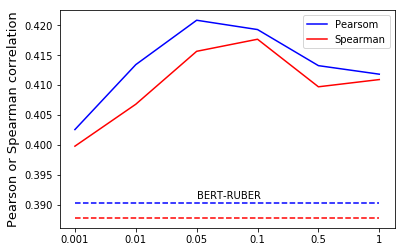

In [24]:
# weight temperature ratio show
enp = np.array([0.40255, 0.41342, 0.42085, 0.41929, 0.41325, 0.41182])
ens = np.array([0.39977, 0.40679, 0.41565, 0.41767, 0.40971, 0.41092])
nx = ['0.001', '0.01', '0.05', '0.1', '0.5', '1']
x = np.array(range(len(nx)))

# func = interpolate.interp1d(x, enp, kind='cubic')
# enp_new = func(np.arange(0, 1, 0.001))
# func = interpolate.interp1d(x, ens, kind='cubic')
# ens_new = func(np.arange(0, 1, 0.001))

plt.plot(x, enp, color='blue', label='Pearsom')
plt.plot(x, ens, color='red', label='Spearman')
# plt.plot(x, pnp, color='blue')
# plt.plot(x, pns, color='red')
# plt.plot(x, trpp, color='blue')
# plt.plot(x, trps, color='red')

# text
# plt.text(2.5, 0.422, r'EN',
#          fontdict={'size': 12, 'color': 'black'})

# plt.text(2.5, 0.45, r'PN',
#          fontdict={'size': 12, 'color': 'black'})

# plt.text(2.5, 0.475, r'trPN',
#          fontdict={'size': 12, 'color': 'black'})

plt.hlines(0.39027, 0, 5, colors='blue', linestyles='dashed')
plt.hlines(0.38776, 0, 5, colors='red', linestyles='dashed')
plt.text(2, 0.391, r'BERT-RUBER',
         fontdict={'size': 10, 'color': 'black'})

plt.xticks(x, nx, fontsize=10)
#plt.xlabel('weight temperature ratio', fontsize=13)
plt.ylabel('Pearson or Spearman correlation', fontsize=13)
plt.legend()

# plt.title('Weighted temperature ratio for performance', fontsize=14)
plt.savefig('./img/en.eps', format='eps', dpi=1000)

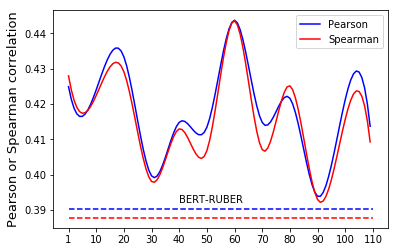

In [16]:
# prechoice ratio show
enp = np.array([0.42489, 0.424, 0.43335, 0.39966, 0.41481, 0.41342, 0.44369, 0.41478, 0.42161, 0.39389, 0.42125, 0.40549])
ens = np.array([0.42794, 0.42241, 0.42911, 0.39807, 0.41294, 0.40679, 0.44352, 0.40708, 0.42512, 0.39297, 0.41568, 0.40146])
nx = ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110']
# nx = ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', ']
x = range(len(nx))

func = interpolate.interp1d(x, enp, kind='cubic')
enp_new = func(np.arange(0, 11, 0.1))
func = interpolate.interp1d(x, ens, kind='cubic')
ens_new = func(np.arange(0, 11, 0.1))

plt.plot(np.arange(0, 11, 0.1), enp_new, color='blue', label='Pearson')
plt.plot(np.arange(0, 11, 0.1), ens_new, color='red', label='Spearman')
# plt.plot(x, enp, color='blue')
# plt.plot(x, ens, color='red')
# plt.plot(x, pnp, color='blue')
# plt.plot(x, pns, color='red')
# plt.plot(x, trpp, color='blue')
# plt.plot(x, trps, color='red')

# text
# plt.text(5, 0.422, r'EN',
#          fontdict={'size': 12, 'color': 'black'})

# plt.text(5, 0.445, r'PN',
#          fontdict={'size': 12, 'color': 'black'})

# plt.text(5, 0.4, r'trPN',
#          fontdict={'size': 12, 'color': 'black'})

plt.hlines(0.39027, 0, 11, colors='blue', linestyles='dashed')
plt.hlines(0.38776, 0, 11, colors='red', linestyles='dashed')
plt.text(4, 0.392, r'BERT-RUBER',
         fontdict={'size': 10, 'color': 'black'})


plt.xticks(x, nx, fontsize=10)
#plt.xlabel('Pre-extracted analyse', fontsize=13)
plt.ylabel('Pearson or Spearman correlation', fontsize=13)
plt.legend()

# plt.title('Pre-extracted influence for performance', fontsize=14)
plt.savefig('./img/prechoice.eps', format='eps', dpi=1000)

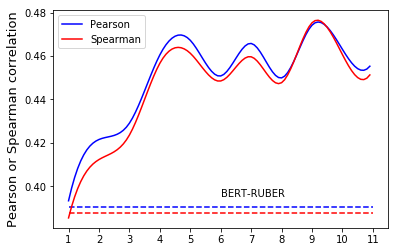

In [17]:
# data augmentation analyse
enp = np.array([0.39329, 0.42155, 0.42908, 0.46058, 0.4673, 0.45086, 0.46585, 0.44996, 0.47429, 0.4631, 0.4575])
ens = np.array([0.38538, 0.4123, 0.4236, 0.45671, 0.46132, 0.44854, 0.4597, 0.44775, 0.47539, 0.46068, 0.4538])
nx = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
x = np.array(range(len(nx)))

func = interpolate.interp1d(x, enp, kind='cubic')
enp_new = func(np.arange(0, 10, 0.1))
func = interpolate.interp1d(x, ens, kind='cubic')
ens_new = func(np.arange(0, 10, 0.1))

plt.plot(np.arange(0, 10, 0.1), enp_new, color='blue', label='Pearson')
plt.plot(np.arange(0, 10, 0.1), ens_new, color='red', label='Spearman')

plt.xticks(x, nx, fontsize=10)
#plt.xlabel('the multiple of the size of original dataset', fontsize=13)
plt.ylabel('Pearson or Spearman correlation', fontsize=13)
plt.hlines(0.39027, 0, 10, colors='blue', linestyles='dashed')
plt.hlines(0.38776, 0, 10, colors='red', linestyles='dashed')

plt.text(5, 0.395, r'BERT-RUBER',
         fontdict={'size': 10, 'color': 'black'})

plt.legend()

# plt.title('The amount of augmentation data for performance', fontsize=14)
plt.savefig('./img/da.eps', format='eps', dpi=1000)

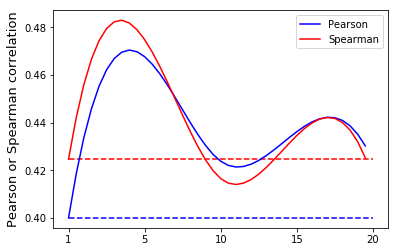

In [23]:
# data augmentation analyse
enp = np.array([0.40004, 0.46771, 0.42382, 0.43623, 0.42382])
ens = np.array([0.42467, 0.47485, 0.41653, 0.43462, 0.41653])
nx = ['1', '5', '10', '15', '20']
x = np.array(range(len(nx)))

func = interpolate.interp1d(x, enp, kind='cubic')
enp_new = func(np.arange(0, 4, 0.1))
func = interpolate.interp1d(x, ens, kind='cubic')
ens_new = func(np.arange(0, 4, 0.1))

plt.plot(np.arange(0, 4, 0.1), enp_new, color='blue', label='Pearson')
plt.plot(np.arange(0, 4, 0.1), ens_new, color='red', label='Spearman')

plt.xticks(x, nx, fontsize=10)
#plt.xlabel('the multiple of the size of original dataset', fontsize=13)
plt.ylabel('Pearson or Spearman correlation', fontsize=13)
plt.hlines(0.40004, 0, 4, colors='blue', linestyles='dashed')
plt.hlines(0.42467, 0, 4, colors='red', linestyles='dashed')

# plt.text(1.5, 0.395, r'BERT-RUBER',
#          fontdict={'size': 10, 'color': 'black'})

plt.legend()

# plt.title('The amount of augmentation data for performance', fontsize=14)
# plt.savefig('./img/da.eps', format='eps', dpi=1000)
plt.savefig('./img/da.eps', format='eps', dpi=1000)

## Decision boundary